In [14]:
import pyspedas
import pytplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modules.calparam import *


#swe_vars = pyspedas.wind.swe(trange=['2003-11-20','2003-11-23'],datatype='h1',varnames=['BX','BY','BZ','Proton_Np_moment','Proton_W_moment'],downloadonly=True,time_clip=True)

**Using CDFLIB**

In [15]:
import cdflib
dt = "20240428"
cdf_file = cdflib.CDF(r'wi_h1_swe_20011208_v01.cdf')

In [16]:
cdf_file.cdf_info()

CDFInfo(CDF=WindowsPath('C:/Users/KEVAL/Desktop/ICME-PRoject/ICME-ML/wi_h1_swe_20011208_v01.cdf'), Version='3.9.1', Encoding=6, Majority='Row_major', rVariables=[], zVariables=['Epoch', 'bx', 'by', 'bz', 'Proton_Np_moment', 'Proton_W_moment', 'Proton_VX_moment', 'Proton_VY_moment', 'Proton_Vz_moment'], Attributes=[], Copyright='\nCommon Data Format (CDF)\nhttps://cdf.gsfc.nasa.gov\nSpace Physics Data Facility\nNASA/Goddard Space Flight Center\nGreenbelt, Maryland 20771 USA\n', Checksum=False, Num_rdim=0, rDim_sizes=[], Compressed=False, LeapSecondUpdate=None)

In [17]:
time_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))
time_range

array(['2001-12-08T00:00:00.000000', '2001-12-08T00:01:32.000000',
       '2001-12-08T00:03:04.000000', '2001-12-08T00:04:36.000000',
       '2001-12-08T00:06:08.000000', '2001-12-08T00:07:40.000000',
       '2001-12-08T00:09:12.000000', '2001-12-08T00:10:44.000000',
       '2001-12-08T00:12:16.000000', '2001-12-08T00:13:48.000000',
       '2001-12-08T00:15:20.000000', '2001-12-08T00:16:52.000000',
       '2001-12-08T00:18:24.000000', '2001-12-08T00:19:56.000000',
       '2001-12-08T00:21:28.000000', '2001-12-08T00:23:00.000000',
       '2001-12-08T00:24:32.000000', '2001-12-08T00:26:04.000000',
       '2001-12-08T00:27:36.000000', '2001-12-08T00:29:08.000000',
       '2001-12-08T00:30:40.000000', '2001-12-08T00:32:12.000000',
       '2001-12-08T00:33:44.000000', '2001-12-08T00:35:16.000000',
       '2001-12-08T00:36:48.000000', '2001-12-08T00:38:20.000000',
       '2001-12-08T00:39:52.000000', '2001-12-08T00:41:24.000000',
       '2001-12-08T00:42:56.000000', '2001-12-08T00:44:28.0000

**MATPLOTLIB**

**Deriving the Parameters**

In [18]:
#plotting variables

from modules.calparam import *


BX,BY,BZ,b_mag = bmagnitude(cdf_file)


p_density = thresold(cdf_file.varget('Proton_Np_moment'),1e4)


vp = Vp_vec(cdf_file)

temp = Temperature(cdf_file)


p_beta = plasma_beta(p_density,b_mag,temp)

tehta_angle,phi_angle = angels(BX,BY,BZ,b_mag)


In [19]:
from modules.plotter import Plotting

plot  = Plotting('test',r'temp')

plot.ipplot(time_range,b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)


# Request 3-days combine dates set logic

In [ ]:
from datetime import datetime, timedelta


def read_files_in_date_range(start_date, end_date):
    current_date = datetime.strptime(start_date, "%d-%m-%Y")
    end_date = datetime.strptime(end_date, "%d-%m-%Y")

    flag =False
    count =0

    while flag!=True:
        
        print(current_date)
        loop_date = current_date
 
        date_log = []
        for day in range(1,4):
            date_log.append(loop_date.strftime("%Y%m%d"))

            if end_date.strftime("%Y%m%d") in date_log:
                flag = True
                loop_date += timedelta(days=1)
                break

            loop_date += timedelta(days=1)
        
        start_trange = date_log[0]
        last_trange = loop_date.strftime("%Y%m%d")

        print(start_trange,last_trange)

        

        count+=1
        date_log =[]
        current_date += timedelta(days=1)

    return count



st  = '01-12-2003'
end = '31-12-2003'




test =  read_files_in_date_range(st, end)


# Master data scrapper

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

#list excel of dataset ->
import requests
from bs4 import BeautifulSoup as bs

data_list =requests.get('https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/')
data_list

years = []
for yr in bs(data_list.content).find_all('a')[4:]:
    years.append(yr.text[:-1])

    

dt = pd.DataFrame({"SWE_H1_YEARS":years})
dt.to_csv('dataset_swe_range.csv',index=False)



data_year = pd.read_csv('dataset_swe_range.csv')['SWE_H1_YEARS']


dt =[]
yr =[]
file =[]
head = True
for yrs in data_year:
    url =f'https://cdaweb.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/{yrs}'

    dataset_response = requests.get(url)
    name_list = [i.text for i in bs(dataset_response.content).find_all('td') if i.text[-3:] =='cdf']
    print("Year -------------->",yrs)
    
    for days in name_list:
 
        dat = datetime.strptime(days.split('_')[3], "%Y%m%d")
        format_date = dat.strftime("%d-%m-%Y")

        year = dat.strftime("%Y")

        dt.append(format_date)
        yr.append(year)
        file.append(days)\

    df = pd.DataFrame({"Year":yr,"Date": dt,'CDF_FILE':file})
    
    df.to_csv("Master_Dataset_SWE_H1_v2.csv", index=False,mode='a',header=head)
    head=False 

    dt =[]
    yr =[]
    file =[]

    



 

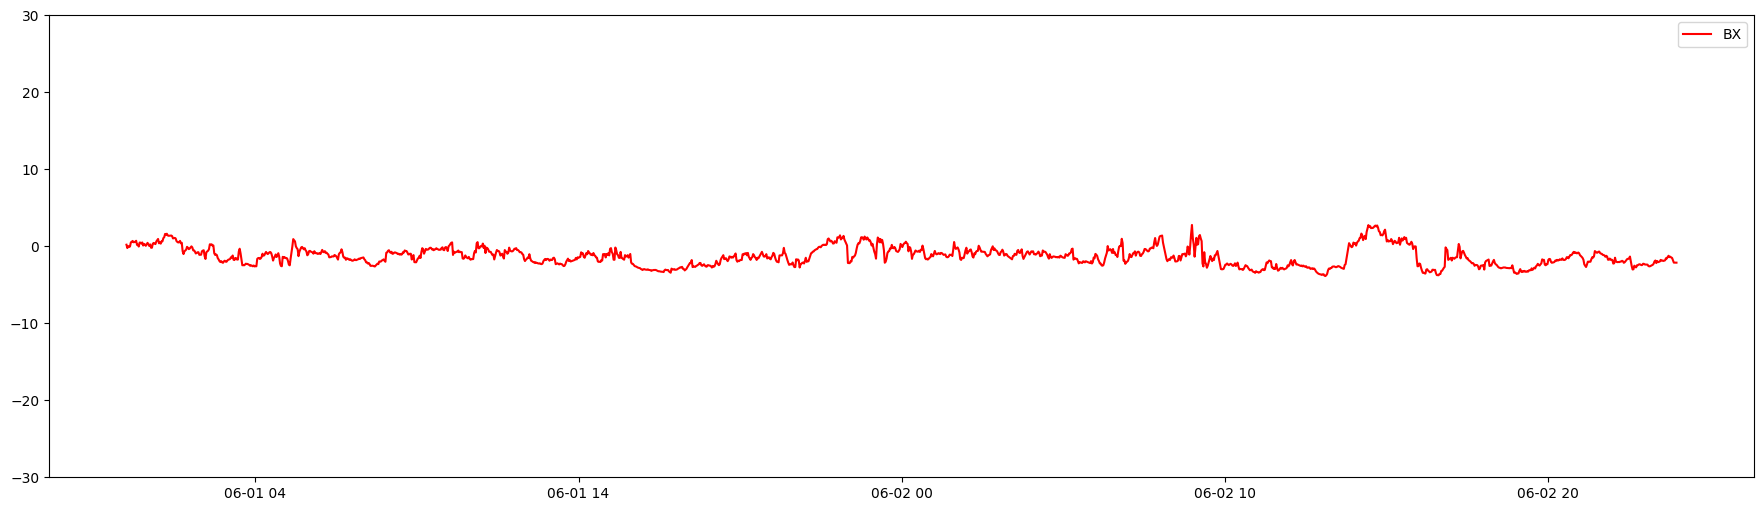

In [185]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


time_range= cdflib.cdfepoch.to_datetime(cdf_file.varget('epoch'))


plt.figure(figsize=(22,6))
plt.ylim(-30,30)
plt.plot(time_range,cdf_file["BX"],color='red',label='BX')

# Add legend
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))

plt.show()

In [ ]:
# from modules.plotter import Plotting
# import matplotlib.pyplot as plt
# # plt.ioff()
# plot  = Plotting()

# t = plot.ipplot(days_3['t_range'],b_mag,BX,BY,BZ,tehta_angle,phi_angle,vp,p_density,temp,p_beta)

# t.savefig('myimage2.jpg', format='jpg', dpi=300)

In [4]:
import cdflib

cdf  = cdflib.CDF(r"download\combined\1998\wi_h1_swe_19980102 - 19980104.cdf")

In [5]:
time_range= cdflib.cdfepoch.to_datetime(cdf.varget('epoch'))

In [1]:
import numpy as np

# Generate 3 dates: 18 Jan 2001, 19 Jan 2001, 20 Jan 2001
dates = [np.datetime64('2001-01-18'), np.datetime64('2001-01-19'), np.datetime64('2001-01-20')]

# Generate time range list in 92-second intervals
time_range = []
for date in dates:
    for i in range(0, 86400, 92):  # 86400 is the number of seconds in a day
        time_range.append(date + np.timedelta64(i, 's'))

print(time_range)

[numpy.datetime64('2001-01-18T00:00:00'), numpy.datetime64('2001-01-18T00:01:32'), numpy.datetime64('2001-01-18T00:03:04'), numpy.datetime64('2001-01-18T00:04:36'), numpy.datetime64('2001-01-18T00:06:08'), numpy.datetime64('2001-01-18T00:07:40'), numpy.datetime64('2001-01-18T00:09:12'), numpy.datetime64('2001-01-18T00:10:44'), numpy.datetime64('2001-01-18T00:12:16'), numpy.datetime64('2001-01-18T00:13:48'), numpy.datetime64('2001-01-18T00:15:20'), numpy.datetime64('2001-01-18T00:16:52'), numpy.datetime64('2001-01-18T00:18:24'), numpy.datetime64('2001-01-18T00:19:56'), numpy.datetime64('2001-01-18T00:21:28'), numpy.datetime64('2001-01-18T00:23:00'), numpy.datetime64('2001-01-18T00:24:32'), numpy.datetime64('2001-01-18T00:26:04'), numpy.datetime64('2001-01-18T00:27:36'), numpy.datetime64('2001-01-18T00:29:08'), numpy.datetime64('2001-01-18T00:30:40'), numpy.datetime64('2001-01-18T00:32:12'), numpy.datetime64('2001-01-18T00:33:44'), numpy.datetime64('2001-01-18T00:35:16'), numpy.datetime6

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

# Sample date range list in 92 sec intervals
date_range = time_range

# Generate random y-data
y_data = np.random.rand(len(date_range))

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20,6))

# Plot the dates on the x-axis and y-data on the y-axis
ax.plot(time_range, cdf['BY'])

date_formatter = mdates.DateFormatter('%Y-%m-%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)

# Set the x-axis major ticks to show specific dates and times
ax.xaxis.set_major_locator(mdates.HourLocator([0,12]))

# Set the x-axis minor ticks to show every hour
ax.xaxis.set_minor_locator(mdates.HourLocator())
# ax.set_xlim(time_range[0], time_range[-1])
date0= time_range[0].astype(datetime.datetime).date()
datelst =time_range[-1].astype(datetime.datetime).date()
# ax.set_xlim([np.datetime64(str(date0)+'T00:00:00'), np.datetime64(str(datelst)+'T00:00:00')])

# Show the plot
plt.xlabel('Date', labelpad=20)
plt.show()

In [34]:
time_range[0]

numpy.datetime64('1994-12-01T08:02:08.766000')